Lisa LAM and Léane SALAIS

## Dice Battle, a game with two players

Two players face each other in a dice game. The goal is to be the first to reach at least N points. In every turn, the 
player choose to throw between 1 and D dices (common six-sided dices). The number of points scored is 1 if the result of one of the dices is 1. Otherwise, it's the sum of the dices.
We will study two variants of this game : 
- sequential variant : the two players play in turn (the first player has then an advantage)
- simultaneous variant : the players play at the same time. If they both reach N points or more, it's the player that exceeds the most N points that wins. If both have exactly N points, they are tied.

The purpose of this project is to determine an optimal game strategy (and to test this strategy against other strategies). If a player wins, his gain is 1. If he lost, his gain is -1. If the game is tied, his gain is 0. It is therefore a zero-sum game.

In [1]:
import numpy as np
import random
import time
from pulp import *
import matplotlib.pyplot as plt

## >>> Strategy class

The Strategy class contains the methods shared by both the sequential and simultaneous game. In particular, there is the two methods that allows us to compute some helpful probabilities :
- P(d,k) : the probability to obtain k points when throwing d dices (d = 1,...,D)
- Q(d,k) : the probability to obtain k points when throwing d dices knowing that we didn't obtain 1

In [2]:
class Strategy(object):
    
    def __init__(self,N,D):
        # Game parameters : N is the number of points to reach to win, D is the maximum number of dices 
        # that a player can throw
        self.N = N
        self.D = D
        
        # MQ will contain de Q(d,k)
        self.MQ = np.ones((self.D+1,self.N+6*self.D))*np.inf 
        # MP will contain the P(d,k)
        self.MP = np.ones((self.D+1,self.N+6*self.D))*np.inf
    
    def Q(self,d,k):
        """
        integer*integer -> float
        input : d dices and k
        output : the probability to obtain k points when throwing d dices
                 knowing that we didn't obtain 1
        """
        # base case : unreachable scores
        if k < 2*d or k > 6*d:                                 
            return 0 
        # basic case : one-in-five chance to get 2, 3, 4, 5 or 6 with only one dice
        if d == 1:                                             
            return 1/5
        # returns directly the value if it has already been calculated
        if self.MQ[d,k] != np.inf:                              
            return self.MQ[d,k]
        # else, compute the value and store it in the MQ matrice
        p = np.array([self.Q(d-1,k-j) for j in range(2,7)])     
        self.MQ[d,k] = np.sum(p)/5
        return self.MQ[d,k]

    def P(self,d,k):
        """
        integer*integer -> float
        input : d dices and k
        output : the probability to obtain k points when throwing d dices
        """
        # base case : unreachable scores
        if k > 1 and k < 2*d or k > 6*d+1:                      
            return 0  
        # basic case : the probability to get 1 whatever the number d of dices
        if k == 1:                                              
            return 1-(5/6)**d    
        # returns directly the value if it has already been calculated
        if self.MP[d,k] != np.inf:                              
            return self.MP[d,k]      
        # else, compute the value and store it in the MQ matrice
        self.MP[d,k] = (5/6)**d * self.Q(d,k)                   
        return self.MP[d,k]
    
    def allP(self):
        """
        fill the MP matrice
        """
        for k in range (1,self.N+6*self.D):
            for d in range(1,self.D+1):
                self.MP[d,k] = self.P(d,k)

## >>> _Sequential game_

Three different strategies : 
- the blind strategy where the player throws the number of dices that maximizes his expectation of points
- the random strategy where the player throws a random number of dices
- the optimal strategy where the player adapts his choice sccording to the situation

In [4]:
class Sequential(Strategy):
    
    def __init__(self,N,D):
        Strategy.__init__(self,N,D) 
        
        # MEG matrice store the expectations of gain of a player in every situation,
        # that is to say, whatever his score is (index i) and whatever his opponent's
        # score is (index j)
        self.MEG = np.ones((self.N+1,self.N+6*self.D))*np.inf
        self.MEG[self.N-1:,:] = 1
        self.MEG[:self.N,self.N:] = -1

        # star will contain the optimal responses of the players, the responses that maximizes 
        # the expaectation of gain in every situation
        self.star = np.zeros((self.N,self.N)).astype('int')
        
        # emptyE is True if the MEG matrice has not already been computed, False otherwise
        self.emptyE = True
        
    # ********************* BLIND STRATEGY *********************
    
    def scoremax(self):
        """
        integer -> integer
        input : D is the maximal number of dices that can be thrown in one throw
        output : the number of dices between 1 and D that maximizes the 
                 expectation of points
        """
        d = np.arange(self.D) + 1
        ep = 4*d*(5/6)**d + 1 - (5/6)**d
        return np.argmax(ep) + 1
    
    def blind_strategy(self,i,j):
        """ Il suffit alors de toujours jouer la même chose. """
        return self.scoremax()
    
    
    # ********************* RANDOM STRATEGY *********************
    
    def random_strategy(self,i,j):
        """
        integer*integer -> integer
        input : state (i,j) that corresponds to the situation where the player 1
                have i points, player 2 have j points
                the state (i,j) is not necessary since it's a random choice that don't
                depends on the state but we put it to generalize the way we use the 
                strategies : it will later be easier to code the simulation of a game
        output : a random number of dices
        """
        return random.randint(1,self.D)
    
    
    # ********************* OPTIMAL STRATEGY *********************
    
    def eg(self,i,j):
        """
        integer*integer -> float
        input : state (i,j) that corresponds to the situation where the player 1
                have i points, player 2 have j points
        output : the expectation of gain of player 1 in this situation   
        """
        # returns directly the value if it has already been calculated
        if self.MEG[i,j] != np.inf: 
            return self.MEG[i,j]                                
        mesesp = []                                                              
        sesesp = []                         
        
        # for every choice of d possible
        for d in range(1,self.D+1):                             
            monesp = 0
            sonesp = 0
            # compute the expactation of gain (consider every possible score)
            # we also look at the opponent expectation of gain
            for k in range(1,6*d+1):                            
                monesp += self.MP[d,k]* self.eg(j,i+k)          
                sonesp += self.MP[d,k] * self.eg(i,j+k) 
            mesesp.append(-monesp)
            sesesp.append(-sonesp)
        
        # we only retain the maximum expectation
        self.MEG[i,j] = np.amax(mesesp)                         
        self.star[i,j] = np.argmax(mesesp)+1   
        # to save time : symetrical reasoning in the diagonal
        self.MEG[j,i] = np.amax(sesesp)                        
        self.star[j,i] = np.argmax(sesesp)+1
        return self.MEG[i,j]
                
    def allEG(self):
        """
        compute the MEG matrice
        """
        # compute the MP matrice from the mother class Strategy
        self.allP()     
        for i in range(self.N-1,-1,-1): 
            for j in range(self.N-1,-1,-1):
                self.eg(i,j)                                    
    
    def optimal_strategy(self,i,j):
        """
        return the best choice of d considering the situation
        """
        # if the MEG matrice has not already been computed
        if self.emptyE:                                         
            self.allEG()                              
            self.emptyE = False
        if i==self.N-1 and j==self.N-1: return 1                
        return self.star[i,j]               

## >>> _Simultaneous game_

For the simultaneous game, we use a linear programming package called PuLP.
There are two versions of the game : 
- a one turn game where the players plays simultaneously juste one time
- a general game where they plays simultaneously until N points is reached

In [5]:
class Simultaneous(Strategy):
    
    def __init__(self,N,D):
        Strategy.__init__(self,N,D)   
     
        # p will contain the cum sum of the vector of probability [p1,...,pD] of player 1 
        # computed with the linear program : player 1 will throw d dices with probability pd
        self.p = np.zeros((self.D))
        # emptyE is True if the vector p has not already been computed, False otherwise
        self.clear = True
        
        # MEG matrice store the expectations of gain of a player in every situation,
        # that is to say, whatever his score is (index i) and whatever his opponent's
        # score is (index j)
        self.MEG = np.ones((self.N+6*self.D,self.N+6*self.D))*np.inf
        self.MEG[self.N:,:] = 1
        self.MEG[:self.N,self.N:] = -1
        
        # star will contain the optimal responses of the players, the responses that maximizes 
        # the expaectation of gain in every situation
        self.star = np.zeros((self.N,self.N)).astype('int')
        # emptyE is True if the MEG matrice has not already been computed, False otherwise
        self.emptyE = True

        
    # ********************* ONE TURN GAME *********************

    def eg1(self,d1,d2):
        """
        integer*integer -> float
        input : player 1 throws d1 dices and player 2 d2 dices in a one turn game
        output : the expectation of gain of player 1
        """
        res = 0
        # probability tha player 1 gets more points than player 2
        for k in range(1,6*d1+1):
            temp = 0
            for l in range(1,k):
                temp += self.P(d2,l)
            res += self.P(d1,k)*temp
        # we substract the probaility that player 2 gets more points than player 1
        for k in range(1,6*d2+1):
            temp = 0
            for l in range(1,k):
                temp += self.P(d1,l)
            res -= self.P(d2,k)*temp
        return res
   
    def gain_matrix(self):
        """
        returns the matrice of the expectations of gain of player 1 
        """
        M = np.zeros((self.D,self.D))
        for i in range(self.D):
            for j in range(self.D):
                M[i,j] = self.eg1(i+1,j+1)
        return M
    
    def solve_pl(self):
        """
        returns the vector p = [p1,...,pD] corresponding to the strategy of player 1
        player 1 throws d dices with probability pd
        (see above for the linear program)
        """
        prob = LpProblem("Linear Program", LpMaximize) 
        # creation of p1,...,pD variables
        var = [LpVariable("p%d" % i, lowBound=0, cat='Continuous') for i in range(1,self.D+1)]

        # the objective function is th sum of the variables p1,...,pD
        prob += lpSum(var)  
        
        eg = self.gain_matrix()
        # for each column of eg, add the constraint transpose(p)*eg_column <= 0
        for j in range(self.D): 
            l = []
            for i in range(self.D):
                l.append(-var[i]*eg[i,j])
            prob += lpSum(l) <= 0
        
        # add the constraint that the sum of pi is equal to 1 (probabilities)
        prob += lpSum(var) == 1  

        # compute
        prob.solve()
        prob.writeLP("prob")
        
        # get the solution (rounded to 7 decimals)
        p = []
        for v in var:
            p.append(v.varValue)
        return np.around(np.array(p),7)
    
    def pl_strategy(self,i,j): 
        """
        integer*integer -> integer
        input : state (i,j) that corresponds to the situation where the player 1
                have i points, player 2 have j points
        output : the best choice of d according to the linear program
        """
        # if the vector p has not already been computed
        if self.clear:
            self.p = self.solve_pl().cumsum()
            self.clear = False
        # returns 
        r = random.random()
        d = 0
        while r > self.p[d]:
            d += 1
        return d+1
    
    
    # ********************* GENERAL GAME *********************
    
    def egg(self,i,j):
        """
        calculation of the expactation of gain of player 1 in a situation (i,j) 
        while considering all the possible draws for himself and his opponent
        """
        # returns directly the value if it has already been calculated
        if self.MEG[i,j] != np.inf:
            return self.MEG[i,j]

        monesp = -1
        coupintelligent = 1
        for d1 in range (1,self.D+1):
            maxpertes = 1
            # look for the expectation of gain of the opponent assuming that I play d1 dices
            for d2 in range (1,self.D+1):
                sonesp = np.sum(self.MP[d1,1:6*self.D+1].reshape(6*self.D,1)*self.MP[d2,1:6*self.D+1] * self.MEG[i+1:i+1+6*self.D,j+1:j+1+6*self.D]) 
                maxpertes = min(maxpertes,sonesp)
            # choose the number of dices that maximize his loss
            if (monesp < maxpertes):
                monesp = maxpertes
                coupintelligent = d1
        # complete the matrices
        self.MEG[i,j] = monesp
        self.star[i,j] = coupintelligent
        return self.MEG[i,j]    
    
    def allEggs(self):
        """
        compute the egg matrice
        """
        self.allP()                                            
        for i in range(self.N-1,-1,-1): 
            for j in range(self.N-1,-1,-1):
                self.egg(i,j)                                                         
                    
    def simoptimal_strategy(self,i,j):
        """ Prendre sa décision. """
        # if the matrice egg has not already been computed
        if self.emptyE:                                        
            self.allEggs()                              
            self.emptyE = False
        if i==self.N-1 and j==self.N-1: return 1                
        return self.star[i,j]                                 

## >>> _Game Simulation_

Methods that allows us to play a sequential game (method seqgame) and a simultaneous game (method simgame).

In [6]:
def throw(d):
    """
    integer -> integer
    input : the number d of dicesthat will be thrown
    output : the result according to the rules of the game
    """
    r = np.random.randint(1,6,d)
    # if the result of one of the dices is 1
    if (r == 1).sum() >= 1: return 1
    # else, return the sum of the dices
    else: return np.sum(r)

def seqgame(strat1, strat2, verbose = True, interact = False):
    """
    _ play a sequential game between a player using 'strat1' strategy and a seconf player
    using 'strat2' strategy
    _ if 'verbose' = True, display comments
    _ if 'interact' = True, we can play against the computer using the input function
    WARNING : N is a global variable here
    """
    if interact:
        role = input("Which player would you like to be ?  ")
    score1 = 0
    score2 = 0
    round = 1
    # while no one has won
    while score1 < N and score2 < N:                                      
        if verbose:
            print("\nROUND", round, "\t", score1, "to", score2)           
            print("=======================")
        if interact and int(role) == 1: 
            choix1 = input("Choose your warriors.  ")
        else : choix1 = strat1(score1, score2)                            
        add1 = throw(int(choix1))                                        
        score1 += add1                                                     
        if verbose:                              
            print("Player 1 throws", choix1, "dice")
            print(" >>> Player 1 scores", add1)
        # continue the game, unless player 1 has already won
        if score1 < N:                                                   
            if interact and int(role) == 2: 
                choix2 = input("Choose your warriors.  ")
            else: choix2 = strat2(score2, score1)                           
            add2 = throw(int(choix2))                                     
            score2 += add2 
            if verbose:
                print("Player 2 throws", choix2, "dice")   
                print(" >>> Player 2 scores", add2)
        round += 1
    if verbose: print("\n! FINAL SCORE", score1, "to", score2, "!")       
    # return 1 or 0 to make the calculation of the winrate easier
    if score1 >= N:                                                  
        if verbose: print("Player 1 wins !")
        return 1                                                          
    else:
        if verbose: print("Player 2 wins !")
        return 0
        
def simgame(strat1, strat2, verbose = True, interact = False, oneround = True):
    """
    _ play a simultaneous game between a player using 'strat1' strategy and a seconf player
    using 'strat2' strategy
    _ if 'verbose' = True, display comments
    _ if 'interact' = True, we can play against the computer using the input function
    _ if 'oneround' = True, play a one round game
    WARNING : N is a global variable here
    """
    if interact:
        role = input("Which player would you like to be ?  ")
    score1 = 0
    score2 = 0
    round = 1
    # while no one has won
    while score1 < N and score2 < N:                                       
        if verbose:
            print("\nROUND", round, "\t", score1, "to", score2)            
            print("=======================")
        if interact and int(role) == 1: 
            choix1 = input("Choose your warriors.  ")
        else : choix1 = strat1(score1, score2)                             
        add1 = throw(int(choix1))                                          
        oldscore1 = score1                                                 
        score1 += add1                                                     
        if interact and int(role) == 2: 
            choix2 = input("Choose your warriors.  ")
        else: choix2 = strat2(score2, oldscore1)                           
        add2 = throw(int(choix2))                                          
        score2 += add2 
        if verbose:                      
            print("Player 1 threw", choix1, "dice")
            print(" >>> Player 1 scored", add1)
            print("Player 2 threw", choix2, "dice")   
            print(" >>> Player 2 scored", add2)
        round += 1
        if oneround: break                                                 
    if verbose: print("\n! FINAL SCORE", score1, "to", score2, "!")
    # return 1 or 0 to make the calculation of the winrate easier
    # when they are tied, it is counted as a victory
    if score1 > score2:                                                  
        if verbose: print("Player 1 wins !")
        return 1                                                          
    elif score1 < score2:
        if verbose: print("Player 2 wins !")
        return 0
    else:
        if verbose: print("Erm... Pat ?")
        return 1

## >>> _Sequential Game example_

**Without interaction**

In [7]:
N = int(input("What is the goal to reach ?  "))
D = int(input("How many dice are my friend and I allowed to use ?  "))
seq = Sequential(N,D) 
print("A game starts with", D, "dice below. Whichever player reaches", N, "points first wins.")
seqgame(seq.optimal_strategy, seq.optimal_strategy)

What is the goal to reach ?  100
How many dice are my friend and I allowed to use ?  10
A game starts with 10 dice below. Whichever player reaches 100 points first wins.

ROUND 1 	 0 to 0
Player 1 throws 6 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 20

ROUND 2 	 1 to 20
Player 1 throws 6 dice
 >>> Player 1 scores 1
Player 2 throws 5 dice
 >>> Player 2 scores 17

ROUND 3 	 2 to 37
Player 1 throws 7 dice
 >>> Player 1 scores 1
Player 2 throws 5 dice
 >>> Player 2 scores 16

ROUND 4 	 3 to 53
Player 1 throws 7 dice
 >>> Player 1 scores 29
Player 2 throws 5 dice
 >>> Player 2 scores 17

ROUND 5 	 32 to 70
Player 1 throws 8 dice
 >>> Player 1 scores 1
Player 2 throws 4 dice
 >>> Player 2 scores 12

ROUND 6 	 33 to 82
Player 1 throws 9 dice
 >>> Player 1 scores 1
Player 2 throws 4 dice
 >>> Player 2 scores 1

ROUND 7 	 34 to 83
Player 1 throws 9 dice
 >>> Player 1 scores 1
Player 2 throws 4 dice
 >>> Player 2 scores 1

ROUND 8 	 35 to 84
Player 1 throws 9 dice
 >

0

**With interaction**

In [9]:
seqgame(seq.optimal_strategy, seq.optimal_strategy, interact = True)

Which player would you like to be ?  1

ROUND 1 	 0 to 0
Choose your warriors.  3
Player 1 throws 3 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 2 	 1 to 1
Choose your warriors.  2
Player 1 throws 2 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 3 	 2 to 2
Choose your warriors.  1
Player 1 throws 1 dice
 >>> Player 1 scores 3
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 4 	 5 to 3
Choose your warriors.  2
Player 1 throws 2 dice
 >>> Player 1 scores 7
Player 2 throws 6 dice
 >>> Player 2 scores 23

ROUND 5 	 12 to 26
Choose your warriors.  2
Player 1 throws 2 dice
 >>> Player 1 scores 7
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 6 	 19 to 27
Choose your warriors.  2
Player 1 throws 2 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 7 	 20 to 28
Choose your warriors.  3
Player 1 throws 3 dice
 >>> Player 1 scores 14
Player 2 throws 6 dice
 >>> Player 2 scores 20

ROUND 

0

## >>> _Simultaneous Game example_

**One round game**

In [10]:
sim = Simultaneous(N,D) 
simgame(sim.pl_strategy, seq.blind_strategy) # WARNING ! recovery of the blind strategy in the Sequential game


ROUND 1 	 0 to 0
Player 1 threw 5 dice
 >>> Player 1 scored 1
Player 2 threw 6 dice
 >>> Player 2 scored 1

! FINAL SCORE 1 to 1 !
Erm... Pat ?


1

**General game**

In [ ]:
simgame(sim.simoptimal_strategy, sim.simoptimal_strategy, oneround = False)

**General game with interaction**

In [11]:
simgame(sim.simoptimal_strategy, sim.simoptimal_strategy, interact = True, oneround = False)

Which player would you like to be ?  1

ROUND 1 	 0 to 0
Choose your warriors.  3
Player 1 threw 3 dice
 >>> Player 1 scored 1
Player 2 threw 6 dice
 >>> Player 2 scored 1

ROUND 2 	 1 to 1
Choose your warriors.  5
Player 1 threw 5 dice
 >>> Player 1 scored 1
Player 2 threw 6 dice
 >>> Player 2 scored 1

ROUND 3 	 2 to 2
Choose your warriors.  4
Player 1 threw 4 dice
 >>> Player 1 scored 12
Player 2 threw 6 dice
 >>> Player 2 scored 20

ROUND 4 	 14 to 22
Choose your warriors.  4
Player 1 threw 4 dice
 >>> Player 1 scored 1
Player 2 threw 6 dice
 >>> Player 2 scored 1

ROUND 5 	 15 to 23
Choose your warriors.  3
Player 1 threw 3 dice
 >>> Player 1 scored 10
Player 2 threw 6 dice
 >>> Player 2 scored 1

ROUND 6 	 25 to 24
Choose your warriors.  4
Player 1 threw 4 dice
 >>> Player 1 scored 13
Player 2 threw 6 dice
 >>> Player 2 scored 1

ROUND 7 	 38 to 25
Choose your warriors.  5
Player 1 threw 5 dice
 >>> Player 1 scored 1
Player 2 threw 7 dice
 >>> Player 2 scored 1

ROUND 8 	 39 to 2

1

## >>> _Statistical Tests_

In [13]:
# communal variables for all the tests : play nb_games games
# ns and ds are used for x-axis of the graphs
nb_games = 10000
ns = np.arange(20, 220, 20)
ds = np.arange(2,22,2)

### Sequential game

**Variation of the goal N with the maximum number of dices D fixed.**

In [14]:
# blind vs blind : sequential game
winrates_n_bb = np.zeros((10))
winrates_d_bb = np.zeros((10))
# optimal vs optimal : sequential game
winrates_n_oo = np.zeros((10))
winrates_d_oo = np.zeros((10))
# optimal vs blind : sequential game
winrates_n_ob = np.zeros((10))
winrates_d_ob = np.zeros((10))
# blind against optimal : sequential game
winrates_n_bo = np.zeros((10))
winrates_d_bo = np.zeros((10))

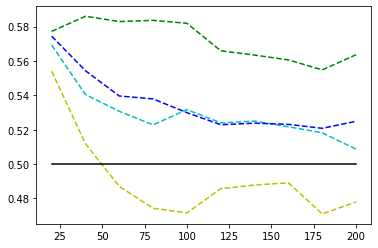

In [16]:
for n in range (20,220,20):
    N = n     # WARNING : N is a global variable for seqgame and simgame
    seq = Sequential(n,10)
    resbb = np.sum(np.array([seqgame(seq.blind_strategy,seq.blind_strategy,False) for i in range(nb_games)]))
    resoo = np.sum(np.array([seqgame(seq.optimal_strategy,seq.optimal_strategy,False) for i in range(nb_games)]))
    resob = np.sum(np.array([seqgame(seq.optimal_strategy,seq.blind_strategy,False) for i in range(nb_games)]))
    resbo = np.sum(np.array([seqgame(seq.blind_strategy,seq.optimal_strategy,False) for i in range(nb_games)]))
    winrates_n_bb[int((n-20)/20)] = resbb/nb_games
    winrates_n_oo[int((n-20)/20)] = resoo/nb_games
    winrates_n_ob[int((n-20)/20)] = resob/nb_games
    winrates_n_bo[int((n-20)/20)] = resbo/nb_games
    
plt.figure()
plt.plot(ns, winrates_n_bb, 'c--', ns, winrates_n_oo, 'b--', ns, winrates_n_ob, 'g--', ns, winrates_n_bo, 'y--', ns, np.full(ns.shape,0.5),'k')
plt.show()

x-axis : variation of the goal N, y-axis : percentage of victory of player 1, light blue : blind vs blind, dark blue : optimal vs optimal, green : optimal vs blind, yellow : blind against optimal, black : line at y = 0.5 (to help the analysis of the graph)
When the players choose the same strategy, the first player has more victories (+4% in the expectation of gain on average) : in the sequential game the first player has indeed an advantage. The optimal strategy accentuate this advantage (+7%) when it plays first against the blind strategy.

**Variation of the maximum number of dices D with the goal N fixed.**

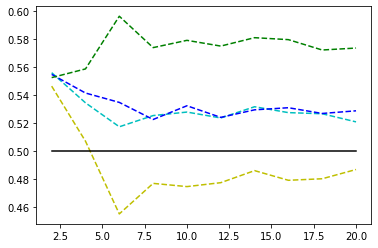

In [17]:
N = 100
for d in range (2,22,2):
    seq = Sequential(N,d)
    resbb = np.sum(np.array([seqgame(seq.blind_strategy,seq.blind_strategy,False) for i in range(nb_games)]))
    resoo = np.sum(np.array([seqgame(seq.optimal_strategy,seq.optimal_strategy,False) for i in range(nb_games)]))
    resob = np.sum(np.array([seqgame(seq.optimal_strategy,seq.blind_strategy,False) for i in range(nb_games)]))
    resbo = np.sum(np.array([seqgame(seq.blind_strategy,seq.optimal_strategy,False) for i in range(nb_games)]))
    winrates_d_bb[int((d-2)/2)] = resbb/nb_games
    winrates_d_oo[int((d-2)/2)] = resoo/nb_games
    winrates_d_ob[int((d-2)/2)] = resob/nb_games
    winrates_d_bo[int((d-2)/2)] = resbo/nb_games

plt.figure()
plt.plot(ds, winrates_d_bb, 'c--', ds, winrates_d_oo, 'b--', ds, winrates_d_ob, 'g--', ds, winrates_d_bo, 'y--', ds, np.full(ns.shape,0.5),'k')
plt.show()

x-axis : variation of the maximum number of dices D\
y-axis : percentage of victory of player 1\
light blue : blind vs blind\
dark blue : optimal vs optimal\
green : optimal vs blind_
yellow : blind against optimal\
black : line at y = 0.5 (to help the analysis of the graph)

**Tests with random strategy**

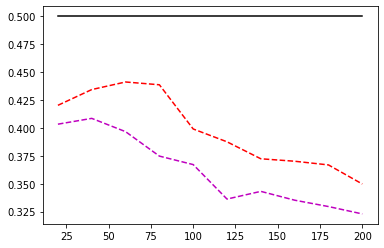

In [18]:
# random vs blind : sequential game
winrates_n_ab = np.zeros((10))
winrates_d_ab = np.zeros((10))
# random vs optimal : sequential game
winrates_n_ao = np.zeros((10))
winrates_d_ao = np.zeros((10))
    
for n in range (20,220,20):
    N = n    # WARNING : N is a global variable for seqgame and simgame
    seq = Sequential(n,10)
    resab = np.sum(np.array([seqgame(seq.random_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    resao = np.sum(np.array([seqgame(seq.random_strategy,seq.optimal_strategy,False) for i in range(nb_parties)]))
    winrates_n_ab[int((n-20)/20)] = resab/nb_parties
    winrates_n_ao[int((n-20)/20)] = resao/nb_parties

plt.figure()
plt.plot(ns, winrates_n_ab, 'r--', ns, winrates_n_ao, 'm--', ns, np.full(ns.shape,0.5),'k')
plt.show()

x-axis : variation of the goal N\
y-axis : percentage of victory of player 1\
pink : random vs optimal\
red : random vs blind\
black : line at y = 0.5 (to help the analysis of the graph)

As we could have expected, the random strategy is not really effective, even when we give him the advantage to be the player 1.

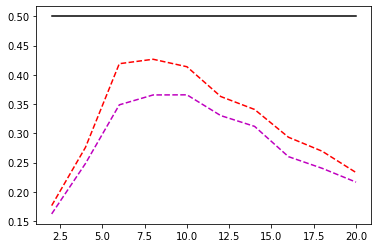

In [19]:
for d in range (2,22,2):
    N = 100
    seq = Sequential(100,d)
    resab = np.sum(np.array([seqgame(seq.random_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    resao = np.sum(np.array([seqgame(seq.random_strategy,seq.optimal_strategy,False) for i in range(nb_parties)]))
    winrates_d_ab[int((d-2)/2)] = resab/nb_parties
    winrates_d_ao[int((d-2)/2)] = resao/nb_parties

plt.figure()
plt.plot(ds, winrates_d_ab, 'r--', ds, winrates_d_ao, 'm--', ds, np.full(ns.shape,0.5),'k')
plt.show()

x-axis : variation of the maximum number of dices D\
y-axis : percentage of victory of player 1\
pink : random vs optimal\
red : random vs blind\
black : line at y = 0.5 (to help the analysis of the graph)

As we could have expected, the random strategy is not really effective, even when we give him the advantage to be the player 1.

### Simultaneous game

**Optimal vs blind**

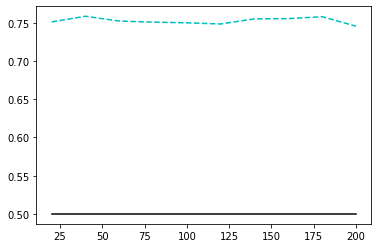

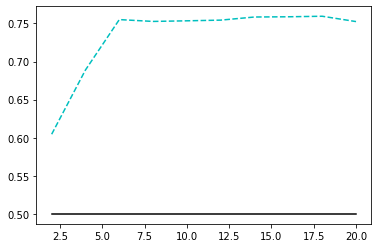

In [45]:
# Optimale contre aveugle : mode simultané
winrates_n_plb = np.zeros((10))
winrates_d_plb = np.zeros((10))

for n in range (20,220,20):
    N = n
    seq = Sequential(n,10)
    sim = Simultaneous(n,10)
    resplb = np.sum(np.array([simgame(sim.pl_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    winrates_n_plb[int((n-20)/20)] = resplb/nb_parties
plt.figure()
plt.plot(ns, winrates_n_plb, 'c--', ns, np.full(ns.shape,0.5),'k')
plt.show()

N = 100
for d in range (2,22,2):
    seq = Sequential(N,d)
    sim = Simultaneous(N,d)
    resplb = np.sum(np.array([simgame(sim.pl_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    winrates_d_plb[int((d-2)/2)] = resplb/nb_parties
    
plt.figure()
plt.plot(ds, winrates_d_plb, 'c--', ds, np.full(ns.shape,0.5),'k')
plt.show()